### add to path 

In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))


Current Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\indirect_identification\notebooks
Parent Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems


# open loop

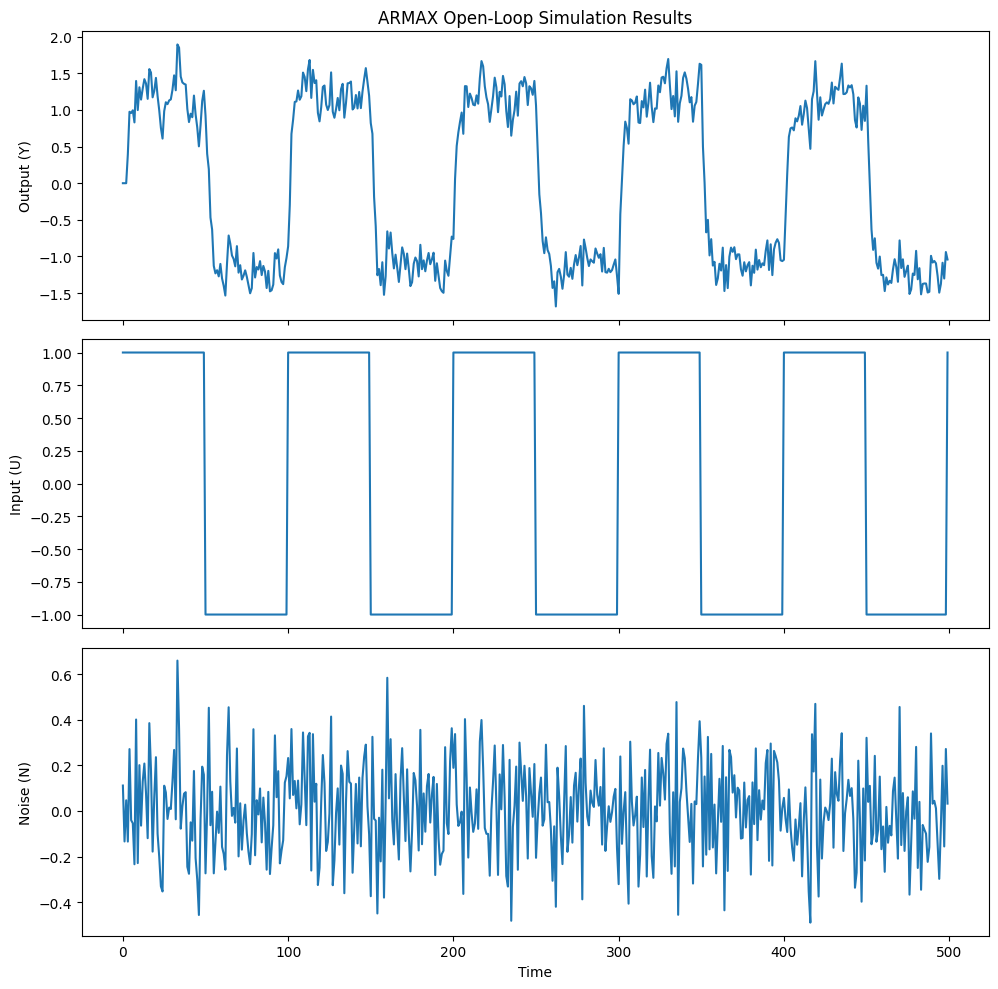

(2, 500) (1, 500)


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

class ARMAX:
    def __init__(self, A, B, C):
        self.A = np.array(A)
        self.B = np.array(B)
        self.C = np.array(C)
    
    def simulate_open_loop(self, n_samples, U=None, noise_std=0.1):
        Y = np.zeros((2, n_samples))
        N = np.random.normal(0, noise_std, n_samples)
        
        if U is None:
            U = np.zeros(n_samples)
        
        max_order = max(len(self.A), len(self.B), len(self.C))
        
        for t in range(max_order, n_samples):
            Y[0,t] = (- np.dot(self.A[1:], Y[0,t-1:t-len(self.A):-1]) 
                    + np.dot(self.B, U[t-1:t-len(self.B)-1:-1])
                    + np.dot(self.C, N[t:t-len(self.C):-1]))
            if t>max_order:
                Y[1,t] = Y[0,t] - Y[0,t-1]

        
        return Y, U, N

    def plot_results(self, Y, U, N, R=None):
        fig, axs = plt.subplots(4 if R is not None else 3, 1, figsize=(10, 10), sharex=True)
        
        axs[0].plot(Y[0])
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Open-Loop Simulation Results')
        
        axs[1].plot(U)
        axs[1].set_ylabel('Input (U)')
        
        axs[2].plot(N)
        axs[2].set_ylabel('Noise (N)')
        
        if R is not None:
            axs[3].plot(R)
            axs[3].set_ylabel('Reference (R)')
            axs[3].set_xlabel('Time')
        else:
            axs[2].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

# Example usage
A = [1, -0.44, -0.1]   # A(z^-1) = 1 - 0.33z^-1 - 0.1z^-2
B = [0.33, 0.2]       # B(z^-1) = 0.22z^-1 + 0.1z^-2
C = [1]               # 

armax_model = ARMAX(A, B, C)

n_samples = 500
U = 1* signal.square(np.linspace(0, 10*np.pi, n_samples))

Y, U, noise = armax_model.simulate_open_loop(n_samples, U, noise_std=0.2)
armax_model.plot_results(Y, U, noise)  # No R needed for open-loop
U = U.reshape(1, -1)
print(Y.shape, U.shape)


In [24]:
from indirect_identification.sps_indirect import SPS_indirect_model
from numba import njit
from indirect_identification.d_tfs import d_tfs, apply_tf_matrix
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _is_stable
from dB.sim_db import SPSType

def get_construct_ss_from_params_method(n_states: int, n_inputs: int, n_outputs: int, C: np.array):
    """
    Returns the function to construct state space matrices from parameters.
    """

    def _construct_ss_from_params(params: np.array):
        """
        Returns state space matrices A_obs,B_obs,C_obs,D_obs and the A,B polynomials
        """
        # A: n_state x n_state matrix
        A =  params[:n_states]
        A_obs = np.hstack([np.vstack([np.zeros(n_states-1), np.eye(n_states-1)]), -np.flipud(A.reshape(A.size,-1))])
        # B: n_state x n_input matrix
        B = params[n_states:n_states+n_states*n_inputs].reshape(n_inputs,n_states)
        B_obs = np.flipud(B.T)
        # C: n_output x n_state matrix
        C_obs = C
        # D: n_output x n_input matrix: zero matrix for now
        D_obs = np.zeros((n_outputs,n_inputs))

        A = np.hstack([1, A])
        B = np.hstack([np.zeros((n_inputs,1)), B])

        return A_obs, B_obs, C_obs, D_obs, A, B
    return _construct_ss_from_params

# Example usage
n_dims=4
center = [-0.44, -0.1, 0.33, 0.2]
C_obs = np.array([[0,1],[1,0]])
epsilon = 1e-10
# sps 
m = 100
q = 5
N = 100

n_output=2
n_states=2
n_inputs=1
model  = SPS_indirect_model(m=m, q=q, N=N, 
                            n_states=2, n_inputs=1, n_outputs=2, 
                            n_noise=-1)
_construct_ss_from_params = get_construct_ss_from_params_method(n_states=2, n_inputs=1, n_outputs=2, C=C_obs)
def is_inside_region(point):
    try :
        A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(point)
        G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)
        if not _is_stable(A, epsilon=epsilon):
            return False
        C = np.empty((n_output, 1))
        H = np.zeros((n_output, n_output), dtype=object)
        for i in range(n_output):
            C[i]=np.array([1])
            H[i,i]=d_tfs((np.array([1.0]),A))
        Lambda = np.array([[1.0, 0],[0, 1.0]]) # shape n_output x n_output
        in_sps = model.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                            Y_t = Y, U_t=U, sps_type=SPSType.OPEN_LOOP, Lambda=None)
    except Exception as e:
        print(f"Error in SPS check: {e}")
        in_sps = False
    return in_sps


model2  = SPS_indirect_model(m=m, q=q, N=N, 
                            n_states=2, n_inputs=1, n_outputs=1, 
                            n_noise=-1)
Y0 = Y[0,:].reshape(1, -1)
_construct_ss_from_params2 = get_construct_ss_from_params_method(n_states=1, n_inputs=1, n_outputs=1, C=np.array([[1]]))
def is_inside_region2(point):
    try :
        A = np.array(point[:2])
        A = np.hstack([1, A])
        B = np.array(point[2:])
        B = np.hstack([0, B])
        G = d_tfs((B, A))
        if not _is_stable(A, epsilon=epsilon):
            return False
        C = np.array([1])
        H = d_tfs((C, A))

        in_sps = model2.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                            Y_t = Y0, U_t=U.reshape(1,-1), sps_type=SPSType.OPEN_LOOP)
    except Exception as e:
        print(f"Error in SPS check: {e}")
        in_sps = False
    return in_sps

# def compute_angular_resolution(dimensions, base=60, growth=2):
#     # angular resolution = base * (growth)^{dimension -2}, ie. 60 directions for 2d
#     return int(base * (growth ** (dimensions - 2)))
# angular_resolution = compute_angular_resolution(dimensions=n_dims)
# print(f"For n_dim = {n_dims}, angular_resolution = {angular_resolution}")
# grid_gen = RadialGrid(
#     center=center,
#     max_radius=100,
#     boundary_tolerance=0.08,
#     angular_resolution=angular_resolution,
#     refinement_factor=1,
#     k=0.5,
#     is_point_in_region_func=is_inside_region,
#     dimensions=n_dims
# )

# points_tested, points_inside, points_outside, boundary_points = grid_gen.generate_grid()
# # Fit a convex hull around inside points

# plot_radial_grid_with_pca(points_inside,None,  boundary_points, dims=n_dims)

print(is_inside_region(np.array(center)))
print(is_inside_region2(np.array(center)))

False
True


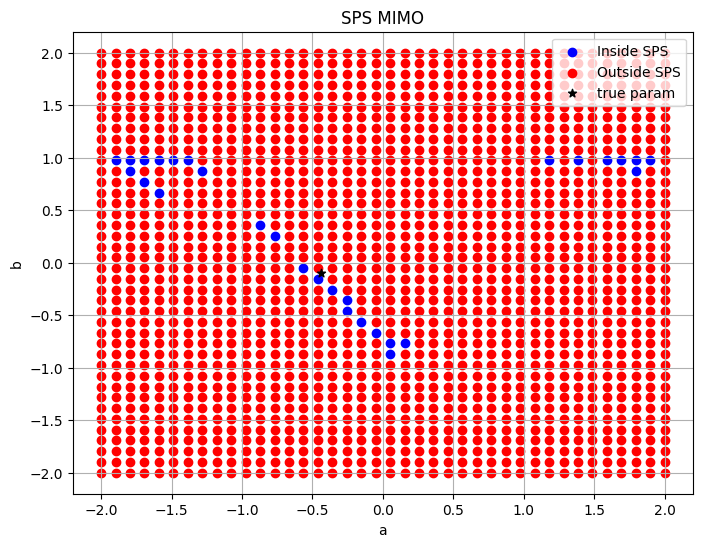

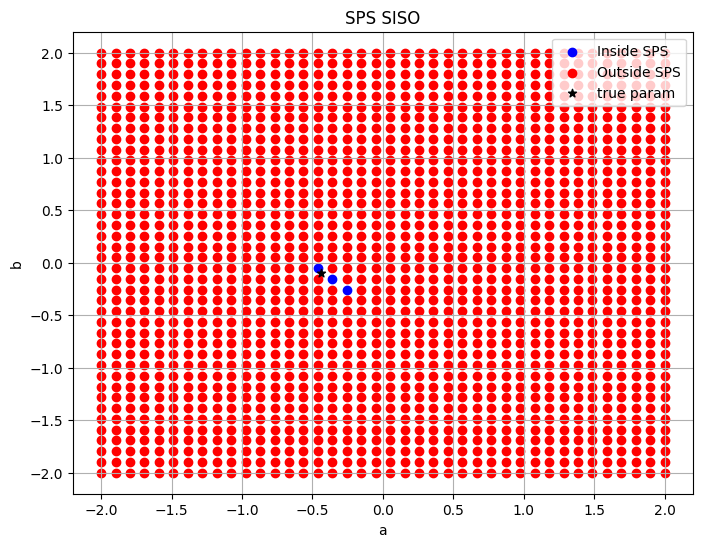

In [25]:

# Grid resolution
a_vals = np.linspace(-2, 2, 40)
b_vals = np.linspace(-2, 2, 40)

blue_pts = []
red_pts = []

for a in a_vals:
    for b in b_vals:
        
        point = np.array([a, b, 0.33, 0.2])
        if is_inside_region(point):
            blue_pts.append([a, b])
        else:
            red_pts.append([a, b])

blue_pts = np.array(blue_pts)
red_pts = np.array(red_pts)

# Plotting
plt.figure(figsize=(8, 6))
if len(blue_pts):
    plt.scatter(blue_pts[:, 0], blue_pts[:, 1], color='blue', label='Inside SPS')
if len(red_pts):
    plt.scatter(red_pts[:, 0], red_pts[:, 1], color='red', label='Outside SPS')
plt.scatter(center[0], center[1], color='black', marker='*', label='true param')
plt.xlabel("a")
plt.ylabel("b")
plt.title("SPS MIMO")
plt.legend()
plt.grid(True)
plt.show()

# Grid resolution
a_vals = np.linspace(-2, 2, 40)
b_vals = np.linspace(-2, 2, 40)

blue_pts = []
red_pts = []

for a in a_vals:
    for b in b_vals:
        
        point = np.array([a, b, 0.33, 0.2])
        if is_inside_region2(point):
            blue_pts.append([a, b])
        else:
            red_pts.append([a, b])

blue_pts = np.array(blue_pts)
red_pts = np.array(red_pts)

# Plotting
plt.figure(figsize=(8, 6))
if len(blue_pts):
    plt.scatter(blue_pts[:, 0], blue_pts[:, 1], color='blue', label='Inside SPS')
if len(red_pts):
    plt.scatter(red_pts[:, 0], red_pts[:, 1], color='red', label='Outside SPS')
plt.scatter(center[0], center[1], color='black', marker='*', label='true param')
plt.xlabel("a")
plt.ylabel("b")
plt.title("SPS SISO")
plt.legend()
plt.grid(True)
plt.show()

# closed loop

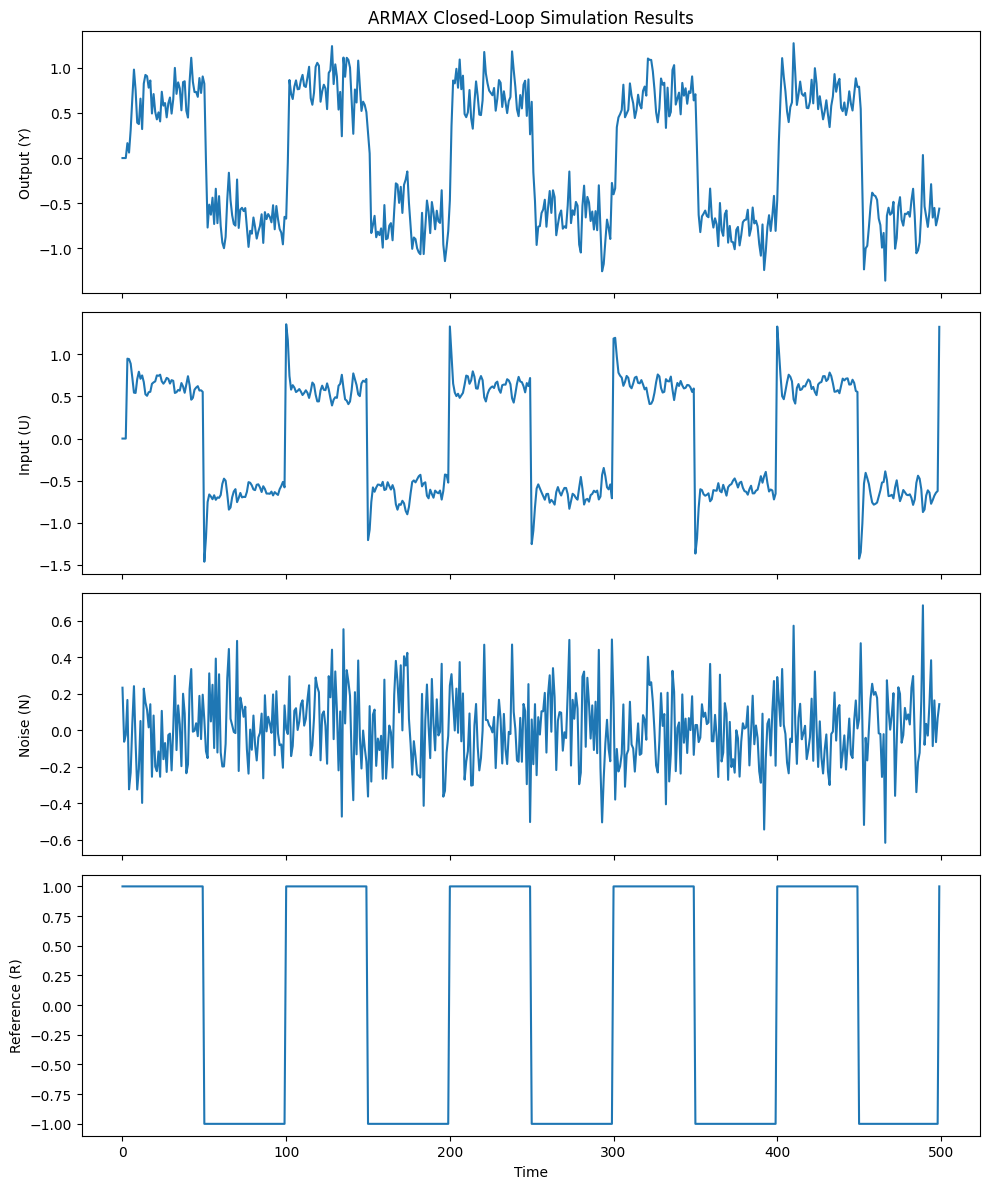

(2, 500) (1, 500) (1, 500)


In [26]:
from indirect_identification.armax import ARMAX
from scipy.signal import lfilter, square
import numpy as np
# Example usage
A = [1.0, -0.44, -0.1]   # A(z^-1) = 1 - 0.33z^-1 - 0.1z^-2
B = [0.33, 0.2]       # B(z^-1) = 0.22z^-1 + 0.1z^-2
C = [1.0]               # C(z^-1) = 1
F = [0.31, 0.23] # F(z^-1) = 0.31 + 0.23z^-1
L = [1.0]        # L(z^-1) = 1

armax_model = ARMAX(A, B, C, F, L)

n_samples = 500
# square wave reference signal
R = square(np.linspace(0, 10*np.pi, n_samples))

Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)
armax_model.plot_results(Y, U, N, R)
# get Y delayed by 1 sample
Y_tm1 = lfilter([1, -1], [1], Y)
Y = np.vstack([Y, Y_tm1])
U = U.reshape(1,-1)
R = R.reshape(1,-1)
print(Y.shape, U.shape, R.shape)

In [27]:
from indirect_identification.sps_indirect import SPS_indirect_model
from numba import njit
from indirect_identification.d_tfs import d_tfs, apply_tf_matrix
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _is_stable
from dB.sim_db import SPSType

def get_construct_ss_from_params_method(n_states: int, n_inputs: int, n_outputs: int, C: np.array):
    """
    Returns the function to construct state space matrices from parameters.
    """

    def _construct_ss_from_params(params: np.array):
        """
        Returns state space matrices A_obs,B_obs,C_obs,D_obs and the A,B polynomials
        """
        # A: n_state x n_state matrix
        A =  params[:n_states]
        A_obs = np.hstack([np.vstack([np.zeros(n_states-1), np.eye(n_states-1)]), -np.flipud(A.reshape(A.size,-1))])
        # B: n_state x n_input matrix
        B = params[n_states:n_states+n_states*n_inputs].reshape(n_inputs,n_states)
        B_obs = np.flipud(B.T)
        # C: n_output x n_state matrix
        C_obs = C
        # D: n_output x n_input matrix: zero matrix for now
        D_obs = np.zeros((n_outputs,n_inputs))

        A = np.hstack([1, A])
        B = np.hstack([np.zeros((n_inputs,1)), B])

        return A_obs, B_obs, C_obs, D_obs, A, B
    return _construct_ss_from_params

# Example usage
n_dims=4
center = [-0.44, -0.1, 0.33, 0.2]
C_obs = np.array([[0,1],[1,0]])
epsilon = 1e-10
# sps 
m = 100
q = 5
N = 100

n_output=2
n_states=2
n_inputs=1
model  = SPS_indirect_model(m=m, q=q, N=N, 
                            n_states=2, n_inputs=1, n_outputs=2, 
                            n_noise=-1)
_construct_ss_from_params = get_construct_ss_from_params_method(n_states=2, n_inputs=1, n_outputs=2, C=C_obs)
def is_inside_region(point):
    try :
        A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(point)
        G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)
        if not _is_stable(A, epsilon=epsilon):
            return False
        C = np.empty((n_output, 1))
        H = np.zeros((n_output, n_output), dtype=object)
        for i in range(n_output):
            C[i]=np.array([1.0])
            H[i,i]=d_tfs((np.array([1.0]),A))
        Lambda = np.array([[1.0, 0],[0, 0.5]]) # shape n_output x n_output

        # F = np.array([d_tfs(([1.31, -0.77],[1.0])), 1.0 ]).reshape(n_inputs, n_output) # input x output
        F = np.array([d_tfs(([0.31, 0.23],[1.0])), 0.0 ]).reshape(n_inputs, n_output) # input x output
    
        L = np.array([[1.0]]).reshape(n_inputs, n_inputs) # input x output
        in_sps = model.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                            Y_t = Y, U_t=U, R_t=R, sps_type=SPSType.CLOSED_LOOP, F=F, L=L, Lambda=None)
    except Exception as e:
        # print(f"Error in SPS check: {e}")
        in_sps = False
    return in_sps


model2  = SPS_indirect_model(m=m, q=q, N=N, 
                            n_states=2, n_inputs=1, n_outputs=1, 
                            n_noise=-1)
Y0 = Y[0,:].reshape(1, -1)
_construct_ss_from_params2 = get_construct_ss_from_params_method(n_states=1, n_inputs=1, n_outputs=1, C=np.array([[1]]))
def is_inside_region2(point):
    try :
        A = np.array(point[:2])
        A = np.hstack([1, A])
        B = np.array(point[2:])
        B = np.hstack([0, B])
        G = d_tfs((B, A))
        if not _is_stable(A, epsilon=epsilon):
            return False
        C = np.array([1.0])
        H = d_tfs((C, A))
        F = d_tfs(([0.31, 0.23], [1.0]))
        L = 1.0
        in_sps = model2.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                            Y_t = Y0, U_t=U.reshape(1,-1), R_t=R.reshape(1,-1), sps_type=SPSType.CLOSED_LOOP, F=F, L=L)
    except Exception as e:
        # print(f"Error in SPS check: {e}")
        in_sps = False
    return in_sps



print(is_inside_region(np.array(center)))
print(is_inside_region2(np.array(center)))

True
True


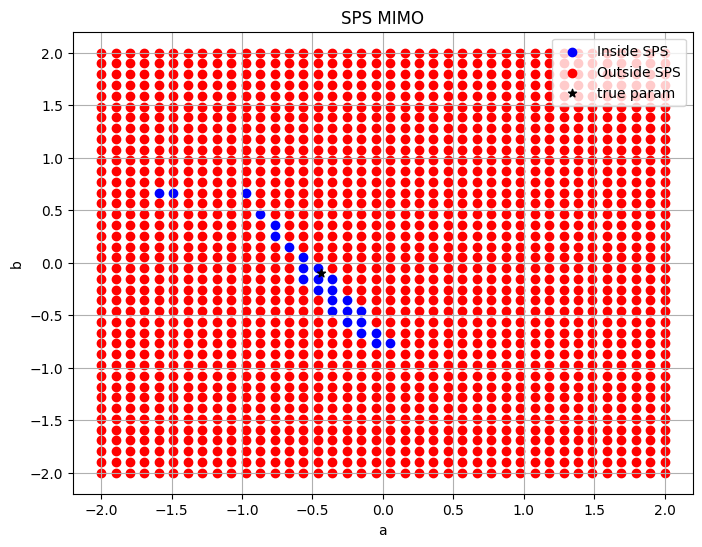

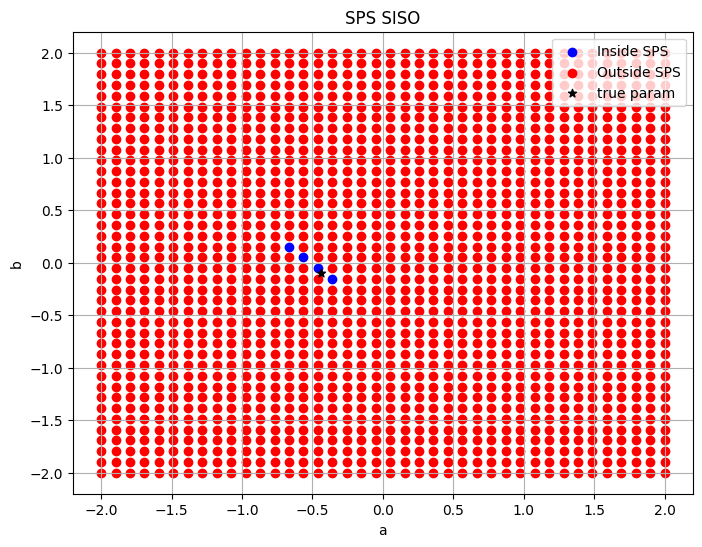

In [28]:
import matplotlib.pyplot as plt
# Grid resolution
a_vals = np.linspace(-2, 2, 40)
b_vals = np.linspace(-2, 2, 40)

blue_pts = []
red_pts = []

for a in a_vals:
    for b in b_vals:
        
        point = np.array([a, b, 0.33, 0.2])
        if is_inside_region(point):
            blue_pts.append([a, b])
        else:
            red_pts.append([a, b])

blue_pts = np.array(blue_pts)
red_pts = np.array(red_pts)

# Plotting
plt.figure(figsize=(8, 6))
if len(blue_pts):
    plt.scatter(blue_pts[:, 0], blue_pts[:, 1], color='blue', label='Inside SPS')
if len(red_pts):
    plt.scatter(red_pts[:, 0], red_pts[:, 1], color='red', label='Outside SPS')
plt.scatter(center[0], center[1], color='black', marker='*', label='true param')
plt.xlabel("a")
plt.ylabel("b")
plt.title("SPS MIMO")
plt.legend()
plt.grid(True)
plt.show()

# Grid resolution
a_vals = np.linspace(-2, 2, 40)
b_vals = np.linspace(-2, 2, 40)

blue_pts = []
red_pts = []

for a in a_vals:
    for b in b_vals:
        
        point = np.array([a, b, 0.33, 0.2])
        if is_inside_region2(point):
            blue_pts.append([a, b])
        else:
            red_pts.append([a, b])

blue_pts = np.array(blue_pts)
red_pts = np.array(red_pts)

# Plotting
plt.figure(figsize=(8, 6))
if len(blue_pts):
    plt.scatter(blue_pts[:, 0], blue_pts[:, 1], color='blue', label='Inside SPS')
if len(red_pts):
    plt.scatter(red_pts[:, 0], red_pts[:, 1], color='red', label='Outside SPS')
plt.scatter(center[0], center[1], color='black', marker='*', label='true param')
plt.xlabel("a")
plt.ylabel("b")
plt.title("SPS SISO")
plt.legend()
plt.grid(True)
plt.show()

# sim test

## open-loop

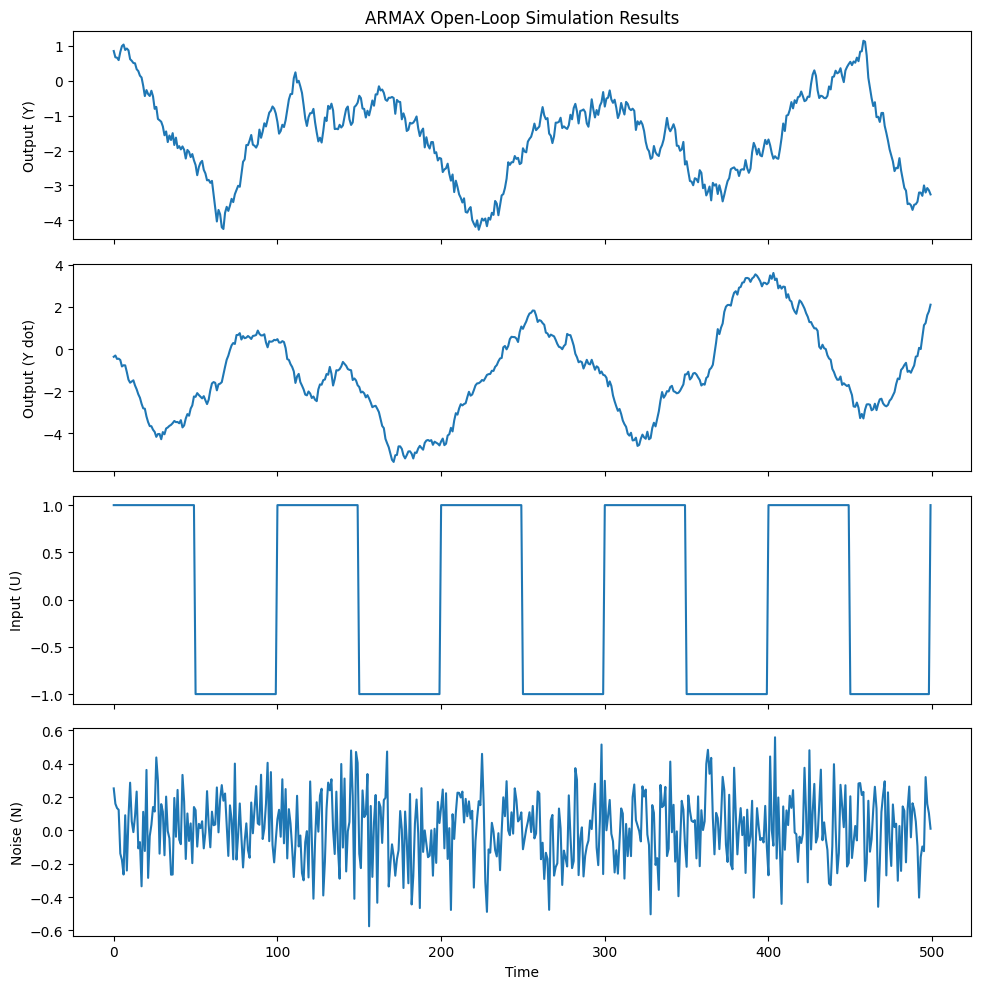

(2, 500) (1, 500)


In [18]:
from sims.pendulum import Pendulum 
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

dt = 0.02
state =  np.array([np.pi/4, 0.0])
noise_std=0.2
n_samples=500
sim = Pendulum(dt=dt, 
                initial_state=state, 
                plot_system=False, 
                history_limit=200, noise_std=noise_std)



U = 1* signal.square(np.linspace(0, 10*np.pi, n_samples))

def simulate_open_loop(n_samples, U=None, noise_std=noise_std, sim=sim):
    Y = np.zeros((2, n_samples))
    N = np.random.normal(0, noise_std, n_samples)
    
    if U is None:
        U = np.zeros(n_samples)
    
    
    for t in range(n_samples):
        _,_,Y[:,t] = sim.step(u=U[t], t=t, full_state=True)
    
    return Y, U, N

def plot_results(Y, U, N):
        fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
        
        axs[0].plot(Y[0])
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Open-Loop Simulation Results')
        
        axs[1].plot(Y[1])
        axs[1].set_ylabel('Output (Y dot)')
        axs[2].plot(U)
        axs[2].set_ylabel('Input (U)')
        
        axs[3].plot(N)
        axs[3].set_ylabel('Noise (N)')
        

        axs[3].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

Y,U,N = simulate_open_loop(n_samples, U, noise_std=noise_std, sim=sim)
plot_results(Y,U,N)
U = U.reshape(1, -1)
print(Y.shape, U.shape)

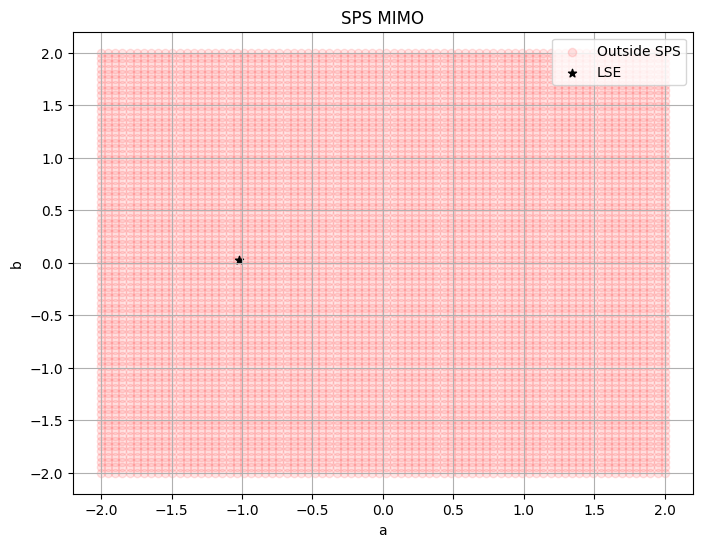

True


In [19]:
from indirect_identification.sps_indirect import SPS_indirect_model
from numba import njit
from indirect_identification.d_tfs import d_tfs, apply_tf_matrix
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _is_stable
from dB.sim_db import SPSType
from scipy import optimize

def get_construct_ss_from_params_method(n_states: int, n_inputs: int, n_outputs: int, C: np.array):
    """
    Returns the function to construct state space matrices from parameters.
    """

    def _construct_ss_from_params(params: np.array):
        """
        Returns state space matrices A_obs,B_obs,C_obs,D_obs and the A,B polynomials
        """
        # A: n_state x n_state matrix
        A =  params[:n_states]
        A_obs = np.hstack([np.vstack([np.zeros(n_states-1), np.eye(n_states-1)]), -np.flipud(A.reshape(A.size,-1))])
        # B: n_state x n_input matrix
        B = params[n_states:n_states+n_states*n_inputs].reshape(n_inputs,n_states)
        B_obs = np.flipud(B.T)
        # C: n_output x n_state matrix
        C_obs = C
        # D: n_output x n_input matrix: zero matrix for now
        D_obs = np.zeros((n_outputs,n_inputs))

        A = np.hstack([1, A])
        B = np.hstack([np.zeros((n_inputs,1)), B])

        return A_obs, B_obs, C_obs, D_obs, A, B
    return _construct_ss_from_params

# Example usage
n_dims=4
C_obs = np.array([[0,1],[1,0]])
epsilon = 1e-10
# sps 
m = 100
q = 5
N = 300

n_output=2
n_states=2
n_inputs=1
model  = SPS_indirect_model(m=m, q=q, N=N, 
                            n_states=2, n_inputs=1, n_outputs=2, 
                            n_noise=-1)
_construct_ss_from_params = get_construct_ss_from_params_method(n_states=2, n_inputs=1, n_outputs=2, C=C_obs)


def get_error_norm(point, Y, U):
    A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(point)
    G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)
    if not _is_stable(A, epsilon=epsilon):
        return 1e10
    C = np.empty((n_output, 1))
    Hinv = np.zeros((n_output, n_output), dtype=object)
    for i in range(n_output):
        C[i]=np.array([1.0])
        Hinv[i,i]=d_tfs((A,np.array([1.0])))

    YGU = Y - apply_tf_matrix(G,U)
    N = apply_tf_matrix(Hinv,YGU)
    Lambda = np.array([[1.0, 0],[0, 1.0]]) # shape n_output x n_output
    error_norm = np.linalg.norm(Lambda@N@N.T)
    return error_norm
def get_lse(Y,U):
    x0 = np.zeros(4)
    res = optimize.least_squares(get_error_norm, x0, args=(Y,U))
    params_ls = res.x
    return params_ls

lse = get_lse(Y,U)

    
def is_inside_region(point):
    try :
        A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(point)
        G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)
        if not _is_stable(A, epsilon=epsilon):
            return False
        C = np.empty((n_output, 1))
        H = np.zeros((n_output, n_output), dtype=object)
        for i in range(n_output):
            C[i]=np.array([1])
            H[i,i]=d_tfs((np.array([1.0]),A))
        Lambda = np.array([[1.0, 0],[0, 1.0]]) # shape n_output x n_output
        in_sps = model.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                            Y_t = Y, U_t=U, sps_type=SPSType.OPEN_LOOP, Lambda=Lambda)
    except Exception as e:
        print(f"Error in SPS check: {e}")
        in_sps = False
    return in_sps

# Grid resolution
a_vals = np.linspace(2, -2, 80)
b_vals = np.linspace(2, -2, 80)

blue_pts = []
red_pts = []

for a in a_vals:
    for b in b_vals:
        
        point = np.array([a, b, lse[2], lse[3]])
        if is_inside_region(point):
            blue_pts.append([a, b])
        else:
            red_pts.append([a, b])

blue_pts = np.array(blue_pts)
red_pts = np.array(red_pts)

# Plotting
plt.figure(figsize=(8, 6))
if len(blue_pts):
    plt.scatter(blue_pts[:, 0], blue_pts[:, 1], color='blue', label='Inside SPS', s=5)
if len(red_pts):
    plt.scatter(red_pts[:, 0], red_pts[:, 1], color='red', label='Outside SPS', alpha=0.1)
plt.scatter(lse[0], lse[1], color='black', marker='*', label='LSE')
plt.xlabel("a")
plt.ylabel("b")
plt.title("SPS MIMO")
plt.legend()
plt.grid(True)
plt.show()


print(is_inside_region(lse))

## closed loop

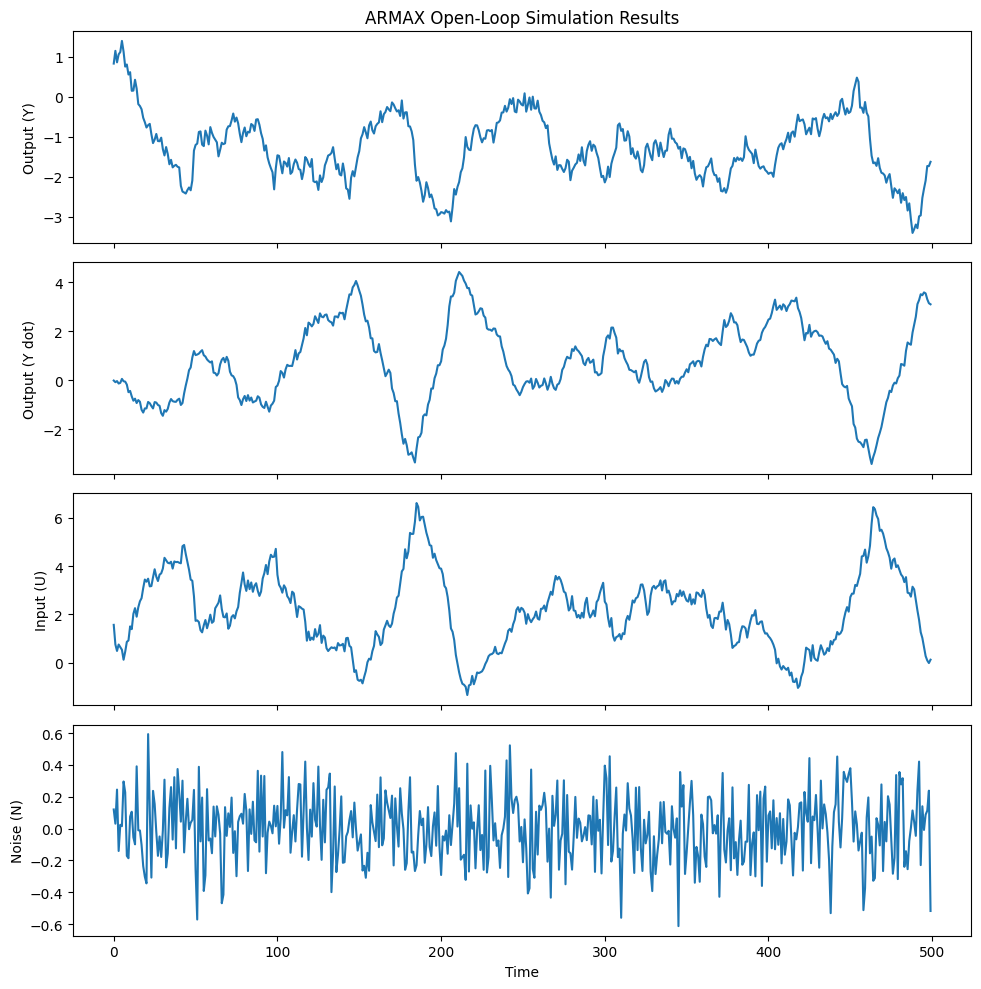

(2, 500) (1, 500) (2, 500)


In [30]:
from sims.pendulum import Pendulum 
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

dt = 0.02
state =  np.array([np.pi/4, 0.0])
noise_std=0.2
n_samples=500
sim = Pendulum(dt=dt, 
                initial_state=state, 
                plot_system=False, 
                history_limit=200, noise_std=noise_std)

F = np.array([1.0, 1.0]).reshape(1,2) # F(z^-1) = 0.31 + 0.23z^-1
L = np.array([1.0, 1.0]).reshape(1,2)        # L(z^-1) = 1

R = np.array([np.pi/2, 0.0]).reshape(2,1)

def simulate_open_loop(n_samples, R, noise_std=noise_std, sim=sim):
    Y = np.zeros((2, n_samples))
    N = np.random.normal(0, noise_std, n_samples)
    U = np.zeros((1,n_samples))
    R_t = np.zeros((2, n_samples))
    
    for t in range(n_samples):
        R_t[:,t] = (R+np.random.normal(0,0.01))[:,0]
        U[:,t] = L@(R_t[:,t]) - F@(Y[:,t-1].reshape(-1,1))
        _,_,Y[:,t] = sim.step(u=U[0,t], t=t, full_state=True)
    
    return Y, U, N, R_t

def plot_results(Y, U, N):
        fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
        
        axs[0].plot(Y[0])
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Open-Loop Simulation Results')
        axs[1].plot(Y[1])
        axs[1].set_ylabel('Output (Y dot)')

        axs[2].plot(U[0])
        axs[2].set_ylabel('Input (U)')

        
        axs[3].plot(N)
        axs[3].set_ylabel('Noise (N)')
        

        axs[3].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

Y,U,N, R = simulate_open_loop(n_samples, R, noise_std=noise_std, sim=sim)
plot_results(Y,U,N)
print(Y.shape, U.shape, R.shape)

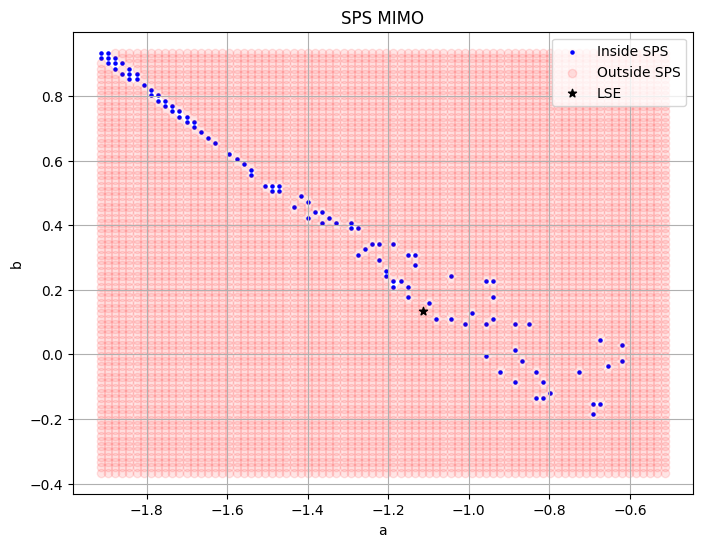

False


In [31]:
from indirect_identification.sps_indirect import SPS_indirect_model
from numba import njit
from indirect_identification.d_tfs import d_tfs, apply_tf_matrix, invert_matrix
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _is_stable
from dB.sim_db import SPSType
import matplotlib.pyplot as plt

def get_construct_ss_from_params_method(n_states: int, n_inputs: int, n_outputs: int, C: np.array):
    """
    Returns the function to construct state space matrices from parameters.
    """

    def _construct_ss_from_params(params: np.array):
        """
        Returns state space matrices A_obs,B_obs,C_obs,D_obs and the A,B polynomials
        """
        # A: n_state x n_state matrix
        A =  params[:n_states]
        A_obs = np.hstack([np.vstack([np.zeros(n_states-1), np.eye(n_states-1)]), -np.flipud(A.reshape(A.size,-1))])
        # B: n_state x n_input matrix
        B = params[n_states:n_states+n_states*n_inputs].reshape(n_inputs,n_states)
        B_obs = np.flipud(B.T)
        # C: n_output x n_state matrix
        C_obs = C
        # D: n_output x n_input matrix: zero matrix for now
        D_obs = np.zeros((n_outputs,n_inputs))

        A = np.hstack([1, A])
        B = np.hstack([np.zeros((n_inputs,1)), B])

        return A_obs, B_obs, C_obs, D_obs, A, B
    return _construct_ss_from_params
def transform_to_open_loop_mimo(G, H, F, L: np.ndarray): 
    # L assumptions
    for tf in L.flat:
        d_tfs.sps_assumption_check(tf=tf, value_check=False, check_stability=True)
    GF_plus_I = (G @ F) + np.eye(G.shape[0])
    i_GF_plus_I = invert_matrix(GF_plus_I)
    for tf in i_GF_plus_I.flat:
            d_tfs.sps_assumption_check(tf=tf, value_check=False, check_stability=True)
    
    G_0 = i_GF_plus_I @ G @ L
    H_0 = i_GF_plus_I @ H
    return G_0, H_0
# Example usage
n_dims=4
C_obs = np.array([[0,1],[1,0]])
epsilon = 1e-10
# sps 
m = 100
q = 5
N = 300

n_output=2
n_states=2
n_inputs=1
model  = SPS_indirect_model(m=m, q=q, N=N, 
                            n_states=2, n_inputs=1, n_outputs=2, 
                            n_noise=-1)
_construct_ss_from_params = get_construct_ss_from_params_method(n_states=2, n_inputs=1, n_outputs=2, C=C_obs)


def get_error_norm(point, Y, U):
    A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(point)
    G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)
    if not _is_stable(A, epsilon=epsilon):
        return 1e10
    C = np.empty((n_output, 1))
    Hinv = np.zeros((n_output, n_output), dtype=object)
    for i in range(n_output):
        C[i]=np.array([1.0])
        Hinv[i,i]=d_tfs((A,np.array([1.0])))

    YGU = Y - apply_tf_matrix(G,U)
    N = apply_tf_matrix(Hinv,YGU)
    Lambda = np.array([[1.0, 0],[0, 1.0]]) # shape n_output x n_output
    error_norm = np.linalg.norm(Lambda@N@N.T)
    return error_norm
def get_lse(Y,U):
    x0 = np.zeros(4)
    res = optimize.least_squares(get_error_norm, x0, args=(Y,U))
    params_ls = res.x
    return params_ls

lse = get_lse(Y,U)


def is_inside_region(point):
    try :
        A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(point)
        G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)
        if not _is_stable(A, epsilon=epsilon):
            return False
        C = np.empty((n_output, 1))
        H = np.zeros((n_output, n_output), dtype=object)
        for i in range(n_output):
            C[i]=np.array([1.0])
            H[i,i]=d_tfs((np.array([1.0]),A))
        Lambda = np.array([[1.0, 0],[0, 1.0]]) # shape n_output x n_output

        # F = np.array([d_tfs(([1.31, -0.77],[1.0])), 1.0 ]).reshape(n_inputs, n_output) # input x output
        
        F = np.array([1.0, 1.0]).reshape(1,2) 
        L = np.array([1.0, 1.0]).reshape(1,2)  
        in_sps = model.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                            Y_t = Y, U_t=U, R_t=R, sps_type=SPSType.CLOSED_LOOP, F=F, L=L, Lambda=Lambda)
    except Exception as e:
        # print(f"Error in SPS check: {e}")
        in_sps = False
    return in_sps


# Grid resolution
a_vals = np.linspace(lse[0]+0.6, lse[0]-0.8, 80)
b_vals =  np.linspace(lse[1]+0.8, lse[1]-0.5, 80)

blue_pts = []
red_pts = []

for a in a_vals:
    for b in b_vals:
        point = np.array([a, b, lse[2], lse[3]])
        if is_inside_region(point):
            blue_pts.append([a, b])
        else:
            red_pts.append([a, b])

blue_pts = np.array(blue_pts)
red_pts = np.array(red_pts)

# Plotting
plt.figure(figsize=(8, 6))
if len(blue_pts):
    plt.scatter(blue_pts[:, 0], blue_pts[:, 1], color='blue', label='Inside SPS',s=5)
if len(red_pts):
    plt.scatter(red_pts[:, 0], red_pts[:, 1], color='red', label='Outside SPS', alpha=0.1)
plt.scatter(lse[0], lse[1], color='black', marker='*', label='LSE')
plt.xlabel("a")
plt.ylabel("b")
plt.title("SPS MIMO")
plt.legend()
plt.grid(True)
plt.show()
print(is_inside_region(lse))

In [32]:
lse

array([-1.11374455,  0.13368035,  0.02175654, -0.04231235])